# ComScore data: Compare demographics with census estimates


#### CPS data

From 2017 estimates from Table HINC-04.
https://www.census.gov/data/tables/time-series/demo/income-poverty/cps-hinc/hinc-04.2017.html

Household Income in 2017:
The CPS 2018 Annual Social and Economic Supplement asked participants to report their household income for 2017.

#### ACS 5-YEAR estimates
Also used for comparison.

[Here](https://api.census.gov/data/2017/acs/acs5/profile/variables.html) is the resource for variables.

In [1]:
import joblib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

from census import Census
import us
from pyzipcode import ZipCodeDatabase


YEAR = 2017 
c = Census("14a343e581b5dd1df551f4cd87f31aede50ec908", year=YEAR)
demographics_fpath = '../data/comscore/{year}/demographics.csv'.format(year=YEAR)

In [2]:
# Plot colors and things
c_census = 'black'
c_comscore = 'purple'

## ComScore data set up

In [3]:
# From the comscore data from the codebook

comscore_demo_codes = pd.DataFrame([
    # education level for head of household
    # 99/3001/3002/3005 Unknown
    [0, 'less than 9th grade', 'hoh_most_education'],
    [1, 'high school graduate', 'hoh_most_education'],
    [2, 'some college, no degree', 'hoh_most_education'],
    [3, 'associates degree', 'hoh_most_education'],
    [4, 'bachelors degree', 'hoh_most_education'],
    [5, 'graduate degree', 'hoh_most_education'],
    
    # Racial Background: 1,2,3,5
    # -88/99 Unknown
    # we assume non-hispanic
    [1, 'white', 'racial_background'], 
    [2, 'black', 'racial_background'],
    [3, 'asian', 'racial_background'],
    [5, 'other', 'racial_background'],
    
    # Country of origin: hispanic / non-hispanic
    [0, 'non-hispanic', 'country_of_origin'],
    [1, 'hispanic', 'country_of_origin'],
    
    # Household income
    # these do not match up well between comScore and ACS data
    # we handle that by collapsing the data (which we also do for other reasons)
    # 99 Unknown
    [11, 'Less than $25,000', 'household_income'],
    [12, '\$25,000 – \$39,999', 'household_income'],
    [13, '\$40,000 – $59,999', 'household_income'],
    [14, '\$60,000 – $74,999', 'household_income'],
    [15, '\$75,000 – $99,999', 'household_income'],
    [16, '\$100,000 to $149,999', 'household_income'],
    [17, '\$150,000 to $199,999', 'household_income'],
    [18, '\$200,000 or more', 'household_income'],
    
], columns=['comscore_code', 'description', 'comscore_column'])
comscore_demo_codes

,comscore_code,description,comscore_column
0,0,less than 9th grade,hoh_most_education
1,1,high school graduate,hoh_most_education
2,2,"some college, no degree",hoh_most_education
3,3,associates degree,hoh_most_education
4,4,bachelors degree,hoh_most_education
5,5,graduate degree,hoh_most_education
6,1,white,racial_background
7,2,black,racial_background
8,3,asian,racial_background
9,5,other,racial_background


Reads in the ComScore demographic data and associate U.S. state via zipcode.

In [4]:
def get_state_fips(zipcode, err=False):
    """
    Returns a state FIPS for the state with given zipcide.
    
    if it can't find the zip code, return np.nan if err=False.
    
    parameters
    ----------
    err: boolean. True if function should raise a ValueError if it can't find a zip code. False by default.
    """
    
    zcdb = ZipCodeDatabase()
    if zipcode not in zcdb:
        if err:
            raise ValueError("Zip code not found")
        else:
            return np.nan
    zipcode = zcdb[zipcode]
    state = us.states.lookup(zipcode.state)
    return state.fips

In [5]:
# drops machine ID since it is not needed for this data exploration
# safer way to show data
# note looking up states takes time
demo_df = (pd.read_csv(demographics_fpath,
                       dtype={'zip_code':str,'household_income':float,
                              'racial_background':float})
            .drop('machine_id', axis=1)
            # make sure zips are zip5
            .assign(zip_code=lambda x: x.zip_code.apply(lambda z: '0' + z if (not pd.isna(z) and len(z) < 5) else z))
            # get state fips code for each zip
            .assign(state_fips=lambda x: x.zip_code.apply(lambda z: get_state_fips(z)))
            .assign(state=lambda x: x.state_fips.apply(lambda s: us.states.lookup(s).abbr if (not pd.isna(s)) else np.nan))
           # replace encodings that represent nan 
           .replace({99:np.nan, -88:np.nan}))
rows = len(demo_df)
print('%s rows' % rows)

93808 rows


In [6]:
demo_df.head()

,hoh_most_education,census_region,household_size,hoh_oldest_age,household_income,children,racial_background,connection_speed,country_of_origin,zip_code,state_fips,state
0,NaN,4.0,5.0,8.0,16.0,0.0,1.0,1.0,0.0,98611,53,WA
1,3.0,4.0,3.0,8.0,14.0,0.0,1.0,1.0,0.0,80910,08,CO
2,4.0,1.0,3.0,11.0,16.0,1.0,1.0,1.0,0.0,07076,34,NJ
3,3.0,2.0,1.0,9.0,16.0,0.0,1.0,1.0,0.0,62554,17,IL
4,NaN,3.0,NaN,4.0,11.0,0.0,NaN,1.0,0.0,NaN,NaN,NaN


## CPS data

In [7]:
cps_df = pd.read_csv('../data/CPS-race.csv', usecols=[0,1,2,3,4],
                      dtype={'income group':str},
                     index_col='income group')
for col in cps_df.columns:
    cps_df[col] = cps_df[col].str.replace(',', '').astype(float)
cps_df

,white alone,black alone,asian alone,total
income group,,,,
Total,100113.0,17019.0,6750.0,127669.0
"Under \$5,000",2739.0,1186.0,280.0,4371.0
"\$5,000 to \$9,999",2154.0,883.0,107.0,3295.0
"\$10,000 to \$14,999",4142.0,1274.0,172.0,5825.0
"\$15,000 to \$19,999",4494.0,1163.0,214.0,6047.0
"\$20,000 to \$24,999",4579.0,1070.0,217.0,6097.0
"\$25,000 to \$29,999",4333.0,963.0,215.0,5738.0
"\$30,000 to \$34,999",4575.0,1103.0,206.0,6100.0
"\$35,000 to \$39,999",4354.0,948.0,218.0,5720.0


make dataframe comparing race for comscore vs CPS

```
racial background, CPS, comscore
```

In [8]:
cps_race_totals = (cps_df.loc['Total']
                   .rename('CPS')
                   .rename({s: s.replace(' alone','') for s in cps_df.columns})
                  ).to_frame()
cps_race_totals.loc['other'] = cps_race_totals.loc['total'] - cps_race_totals.loc[['white','black','asian']].sum()
cps_race_totals = cps_race_totals.drop('total')
cps_race_totals

,CPS
white,100113.0
black,17019.0
asian,6750.0
other,3787.0


In [9]:
comscore_racial_backround = demo_df['racial_background'].value_counts()
comscore_racial_backround

1.0    56153
2.0    17144
5.0    15036
3.0     5463
Name: racial_background, dtype: int64

In [10]:
cps_race_totals['comscore_code'] = comscore_demo_codes[
    (comscore_demo_codes['comscore_column']=='racial_background')
].set_index('description')['comscore_code']
cps_race_totals['comscore'] = cps_race_totals['comscore_code'].map(
    comscore_racial_backround
)
cps_race_totals

,CPS,comscore_code,comscore
white,100113.0,1,56153
black,17019.0,2,17144
asian,6750.0,3,5463
other,3787.0,5,15036


In [11]:
r, pvalue = pearsonr(cps_race_totals['CPS'],
                     cps_race_totals['comscore'])
r, pvalue

(0.9793406448435344, 0.020659355156465553)

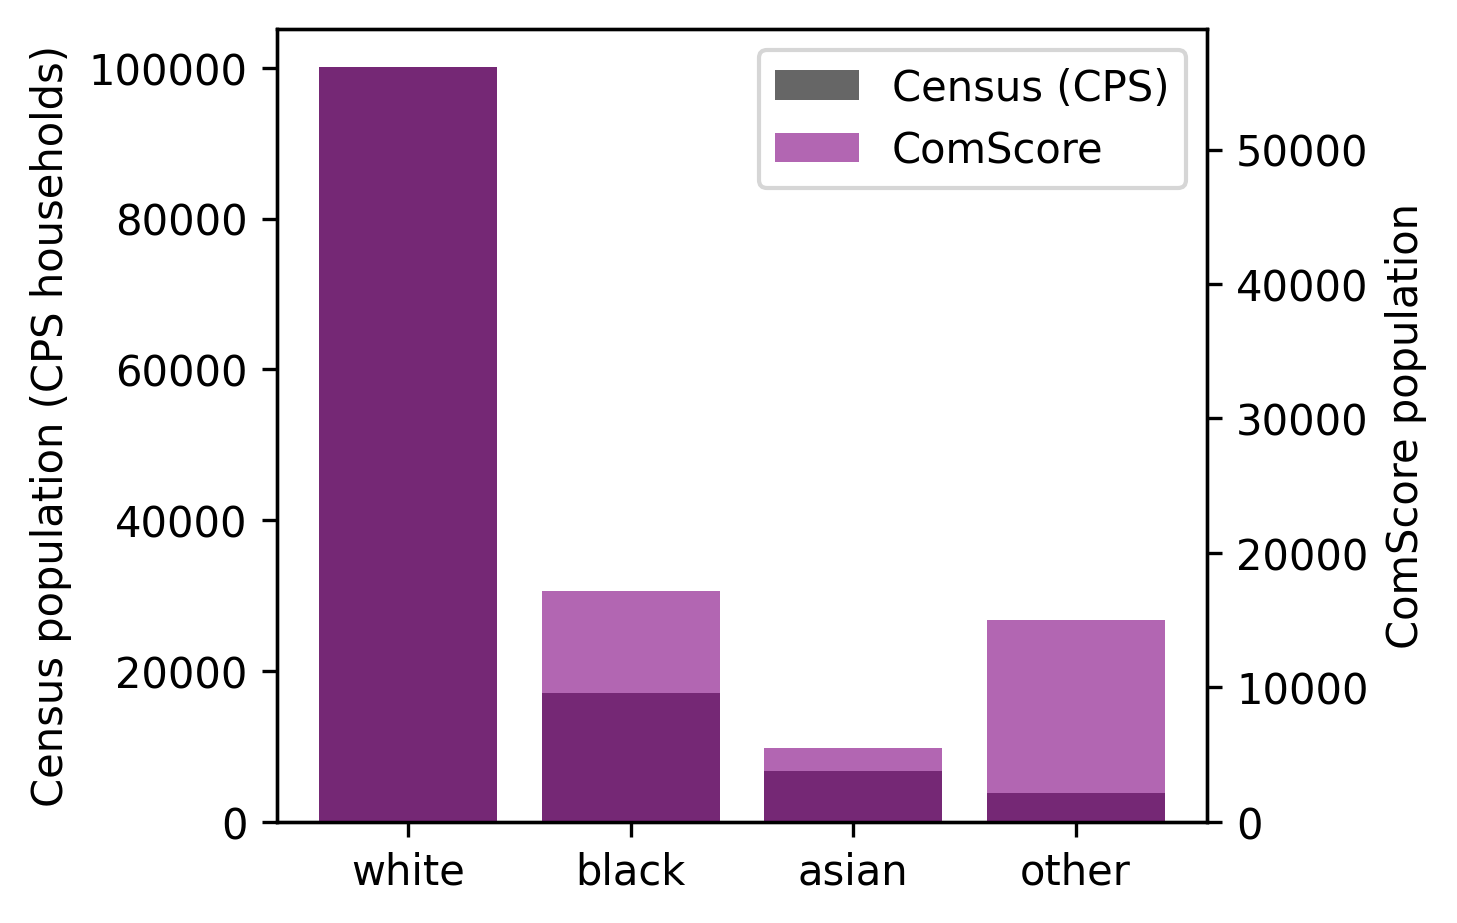

In [12]:
# plot
fig,ax = plt.subplots(1, 1, figsize=(4, 3.5), dpi=300)
ax.bar(
    cps_race_totals.index, cps_race_totals['CPS'],
    color=c_census, alpha=0.6, label='Census (CPS)'
)
ax.ticklabel_format(useOffset=False, axis='y', style='plain')
ax.set_ylabel('Census population (CPS households)')
ax2 = ax.twinx()
ax2.bar(
    cps_race_totals.index, cps_race_totals['comscore'],
    color=c_comscore, alpha=0.6, label='ComScore'
)
ax2.set_ylabel('ComScore population')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
_ = ax2.legend(lines + lines2, labels + labels2, loc=0)

### Income

make dataframe comparing income for comscore vs CPS


There are 8 income categories in the comscore data. We look at these 8 income categories but also collapse them to just 4 categories in order to simplify analysis and data stratification.

- less than \$25,000
- \$25,000 - 75,000
- \$75,000 - 150,000
- \$150,000 or more

In [13]:
comscore_income_codes = comscore_demo_codes[
    comscore_demo_codes['comscore_column']=='household_income'
].copy()
comscore_income_codes['collapsed_code'] = [
    1,2,2,2,3,3,4,4
]
comscore_income_codes['collapsed_desc'] = [
'less than $25,000',
'\$25,000 - $75,000','\$25,000 - $75,000','\$25,000 - $75,000',
'\$75,000 - $150,000','\$75,000 - $150,000',
'\$150,000 or more','\$150,000 or more',
]
comscore_income_codes

,comscore_code,description,comscore_column,collapsed_code,collapsed_desc
12,11,"Less than $25,000",household_income,1,"less than $25,000"
13,12,"\$25,000 – \$39,999",household_income,2,"\$25,000 - $75,000"
14,13,"\$40,000 – $59,999",household_income,2,"\$25,000 - $75,000"
15,14,"\$60,000 – $74,999",household_income,2,"\$25,000 - $75,000"
16,15,"\$75,000 – $99,999",household_income,3,"\$75,000 - $150,000"
17,16,"\$100,000 to $149,999",household_income,3,"\$75,000 - $150,000"
18,17,"\$150,000 to $199,999",household_income,4,"\$150,000 or more"
19,18,"\$200,000 or more",household_income,4,"\$150,000 or more"


In [14]:
cps_comscore_incomes = cps_df.drop('Total')[
    ['total']
].rename(columns={'total':'CPS'})
cps_comscore_incomes['comscore_code'] = [11,11,11,11,11,
                                    12,12,12,
                                    13,13,13,13,
                                    14,14,14,
                                    15,15,15,15,15,
                                    16,16,16,16,16,16,16,16,16,16,
                                    17,17,17,17,17,17,17,17,17,17,
                                    18]
cps_comscore_incomes

,CPS,comscore_code
income group,,
"Under \$5,000",4371.0,11
"\$5,000 to \$9,999",3295.0,11
"\$10,000 to \$14,999",5825.0,11
"\$15,000 to \$19,999",6047.0,11
"\$20,000 to \$24,999",6097.0,11
"\$25,000 to \$29,999",5738.0,12
"\$30,000 to \$34,999",6100.0,12
"\$35,000 to \$39,999",5720.0,12
"\$40,000 to \$44,999",5098.0,13


Show results for the original 8 comscore income groups

In [15]:
cps_comscore_income_groups = cps_comscore_incomes.groupby(
    'comscore_code'
).sum()
cps_comscore_income_groups['comscore'] = demo_df['household_income'].value_counts()
cps_comscore_income_groups['income group'] = comscore_demo_codes[
    comscore_demo_codes.comscore_column == 'household_income'
].set_index('comscore_code')['description']
cps_comscore_income_groups

,CPS,comscore,income group
comscore_code,,,
11,25635.0,21362,"Less than $25,000"
12,17558.0,16066,"\$25,000 – \$39,999"
13,19435.0,16133,"\$40,000 – $59,999"
14,11931.0,8733,"\$60,000 – $74,999"
15,15763.0,11097,"\$75,000 – $99,999"
16,18177.0,11347,"\$100,000 to $149,999"
17,8705.0,4279,"\$150,000 to $199,999"
18,10466.0,4791,"\$200,000 or more"


In [16]:
r, pvalue = pearsonr(cps_comscore_income_groups['CPS'],
                     cps_comscore_income_groups['comscore'])
r, pvalue

(0.9618177639240645, 0.00013520836055118664)

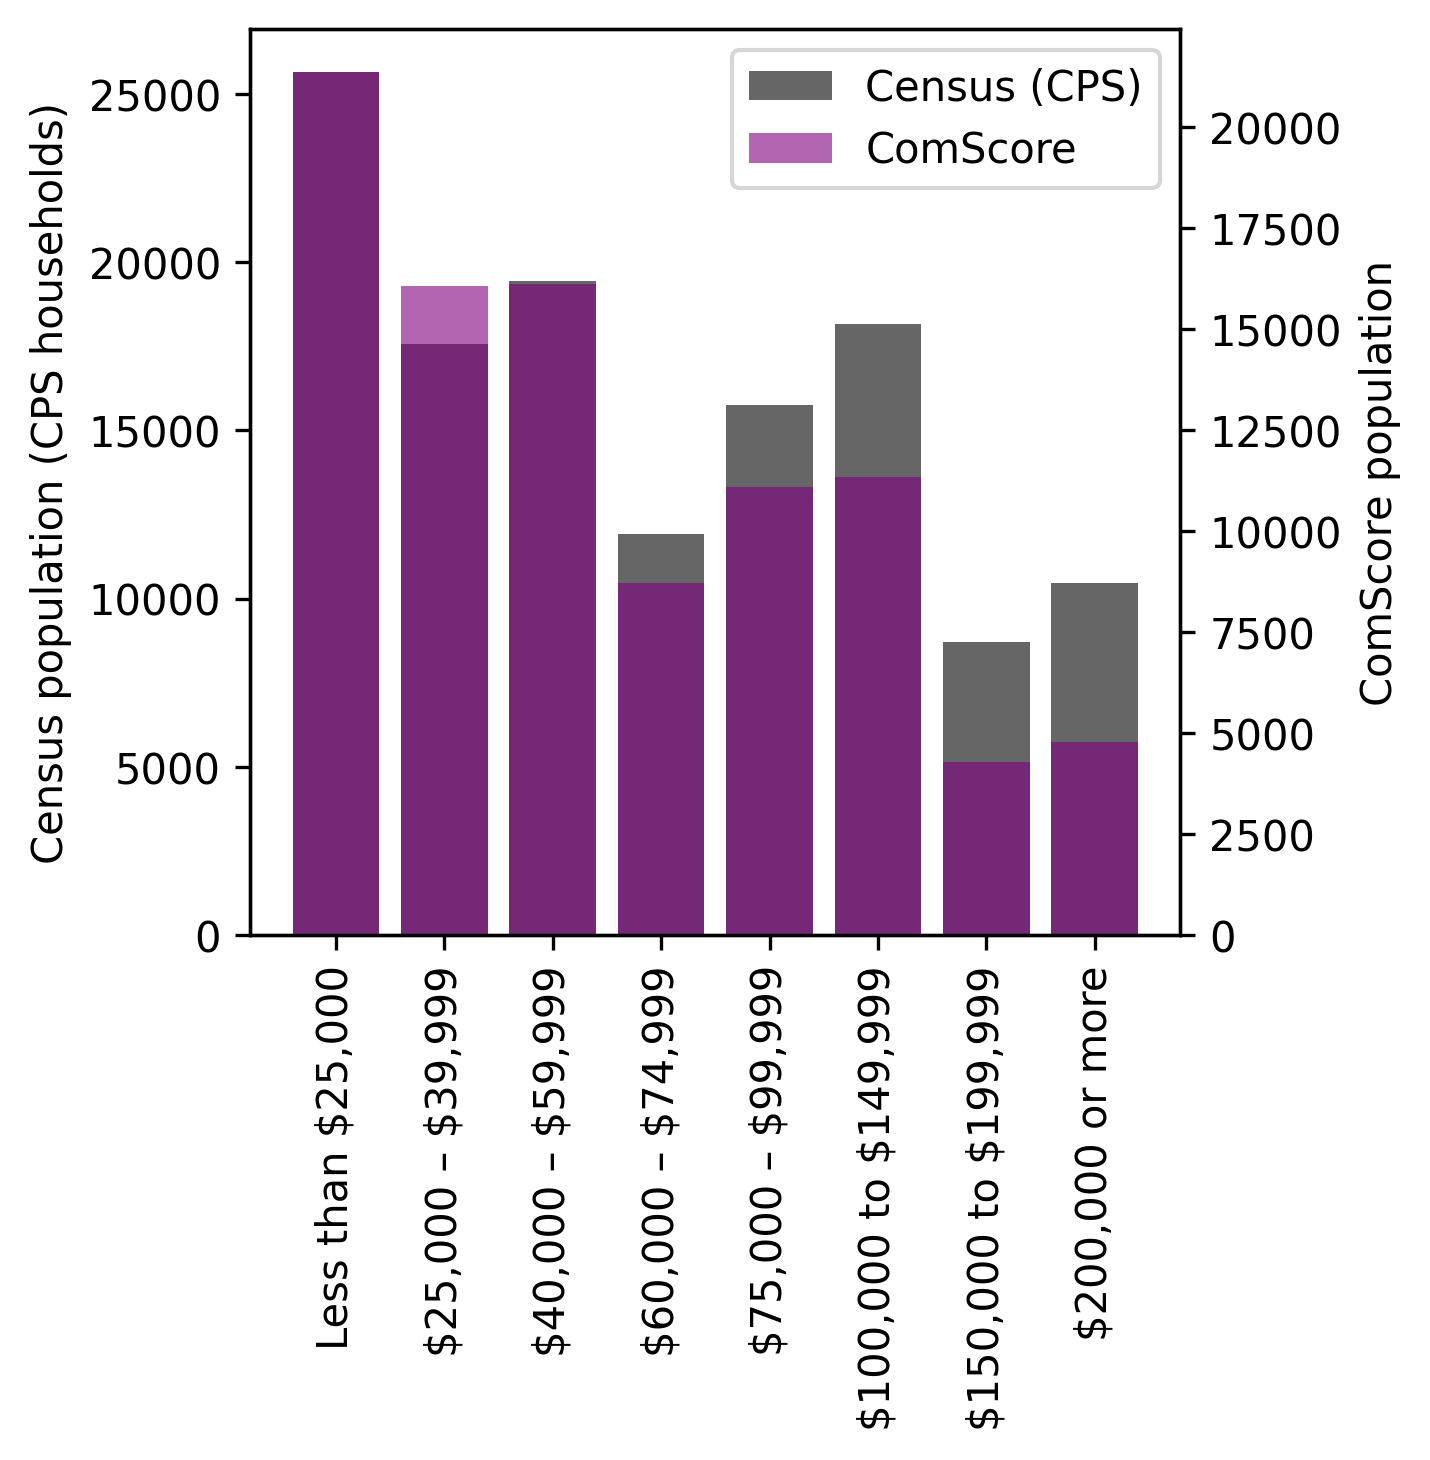

In [17]:
# plot
fig,ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)
ax.bar(
    cps_comscore_income_groups['income group'], cps_comscore_income_groups['CPS'],
    color=c_census, alpha=0.6, label='Census (CPS)'
)
ax.ticklabel_format(useOffset=False, axis='y', style='plain')
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel('Census population (CPS households)')
ax2 = ax.twinx()
ax2.bar(
    cps_comscore_income_groups['income group'], cps_comscore_income_groups['comscore'],
    color=c_comscore, alpha=0.6, label='ComScore'
)
ax2.set_ylabel('ComScore population')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
_ = ax2.legend(lines + lines2, labels + labels2, loc=0)

Show results for the (collapsed) 4 income groups

In [18]:
cps_comscore_income_groups['collapsed_code'] = cps_comscore_income_groups.index.map(
    comscore_income_codes.set_index('comscore_code')['collapsed_code']
)

cps_comscore_income_groups_4 = cps_comscore_income_groups.groupby(
    'collapsed_code'
).sum()
cps_comscore_income_groups_4['income group'] = cps_comscore_income_groups_4.index.map(
    comscore_income_codes.set_index('collapsed_code')['collapsed_desc'].to_dict()
)
cps_comscore_income_groups_4

,CPS,comscore,income group
collapsed_code,,,
1,25635.0,21362,"less than $25,000"
2,48924.0,40932,"\$25,000 - $75,000"
3,33940.0,22444,"\$75,000 - $150,000"
4,19171.0,9070,"\$150,000 or more"


Pearson r = 0.971 (p=0.029)


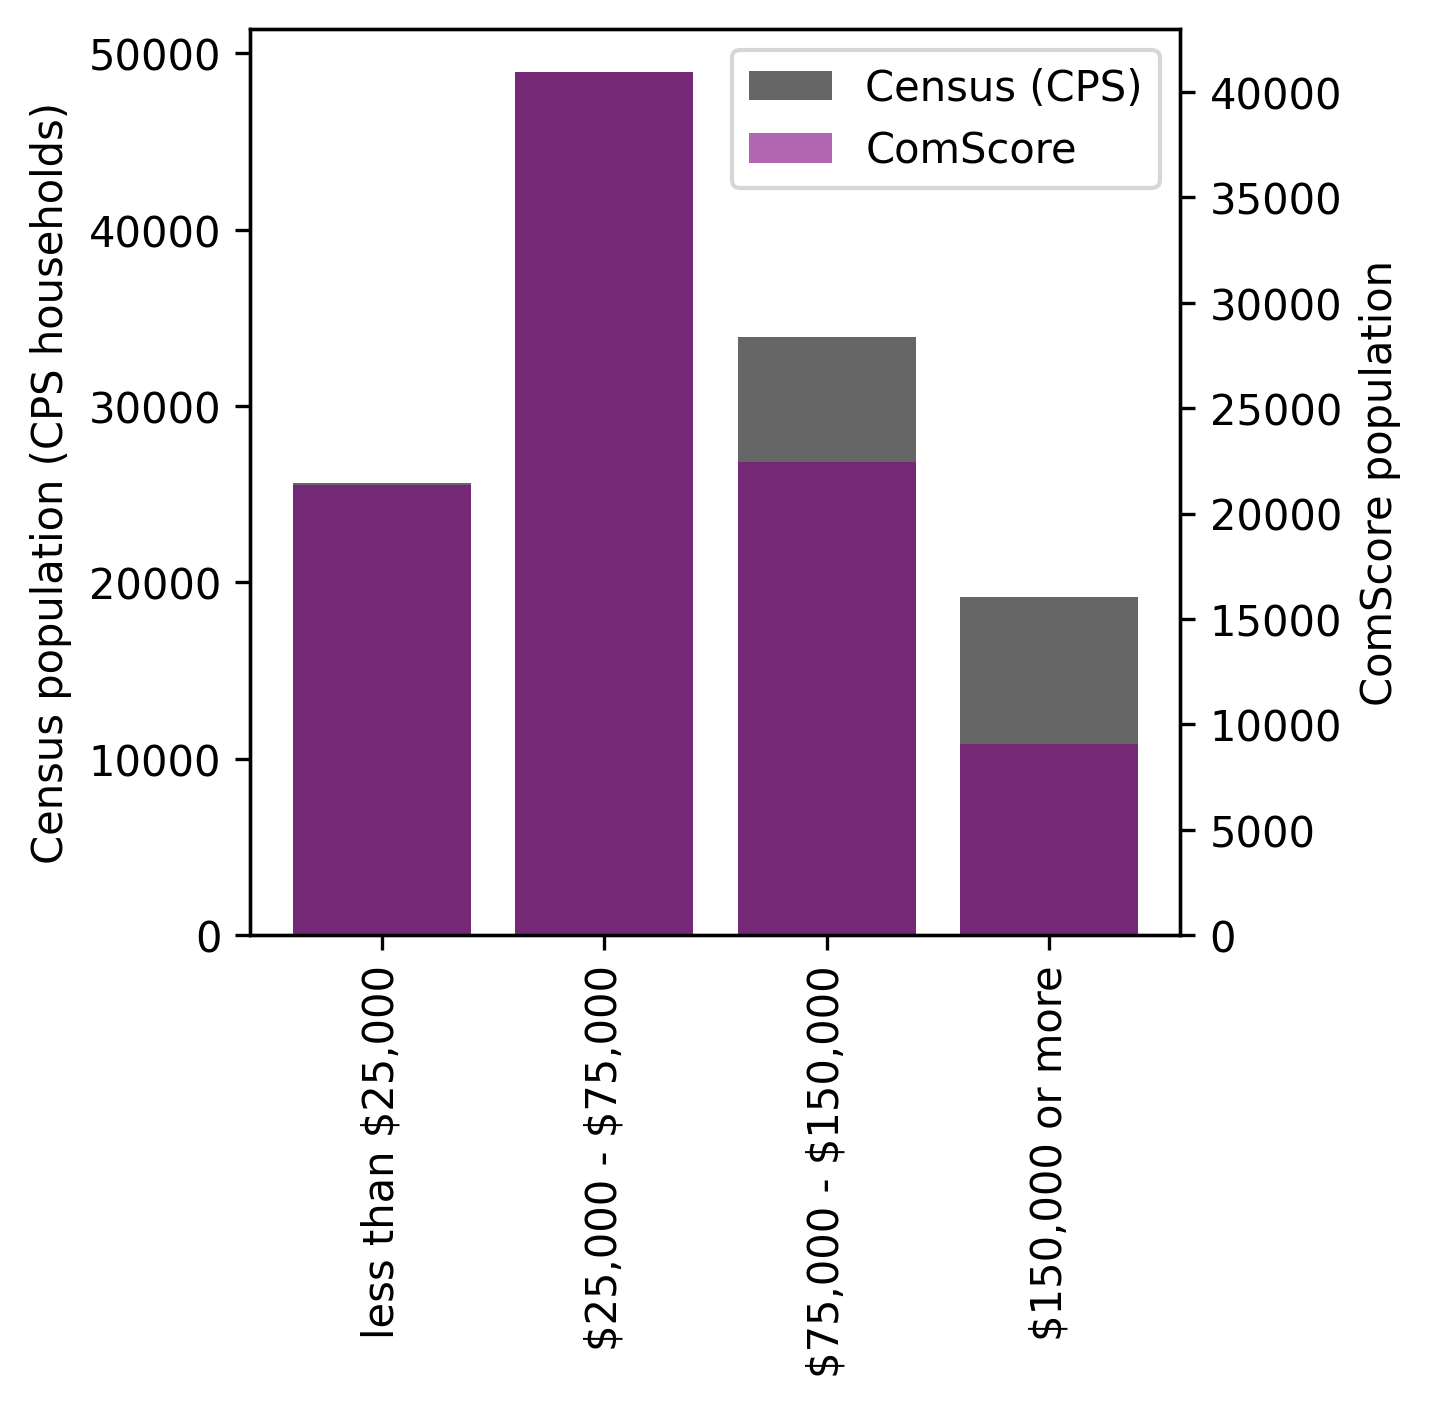

In [19]:
print('Pearson r = %0.3f (p=%0.3f)' % pearsonr(cps_comscore_income_groups_4['CPS'],
         cps_comscore_income_groups_4['comscore']))

# plot
fig,ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)
ax.bar(
    cps_comscore_income_groups_4['income group'],
    cps_comscore_income_groups_4['CPS'],
    color=c_census, alpha=0.6, label='Census (CPS)'
)
ax.ticklabel_format(useOffset=False, axis='y', style='plain')
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel('Census population (CPS households)')
ax2 = ax.twinx()
ax2.bar(
    cps_comscore_income_groups_4['income group'],
    cps_comscore_income_groups_4['comscore'],
    color=c_comscore, alpha=0.6, label='ComScore'
)
ax2.set_ylabel('ComScore population')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
_ = ax2.legend(lines + lines2, labels + labels2, loc=0)

## ACS data

We went [here](https://api.census.gov/data/2017/acs/acs5/profile/variables.html) and looked up relevant variables and just hand-coded them below. We added a mapping to the relevant comscore coding.

In [20]:
acs_mapping = pd.DataFrame([
    # education level. 
    # Note discrepancy: ACS is for individuals > 25 yrs
    # vs ComScore data for head of household
    ['DP02_0064E', 4, 'bachelors degree', 'hoh_most_education'],
    ['DP02_0061E', 1, 'high school graduate', 'hoh_most_education'],
    ['DP02_0065E', 5, 'graduate degree', 'hoh_most_education'],
    ['DP02_0062E', 2, 'some college, no degree', 'hoh_most_education'],
    ['DP02_0063E', 3, 'associates degree', 'hoh_most_education'],
    # two rows for comscore-coded zero. Should sum for comparison.
    ['DP02_0060E', 0, '9-12 grade no diploma', 'hoh_most_education'],
    ['DP02_0059E', 0, 'less than 9th grade', 'hoh_most_education'],
    # Racial Background
    # ComScore uses 1,2,3,5
    # TODO / Question: is non-hispanic encoding right one to use?
    # e.g. instead use DP05_0037PE
    ['DP05_0077E', 1, 'non-hispanic white', 'racial_background'], 
    ['DP05_0078E', 2, 'non-hispanic black', 'racial_background'],
    ['DP05_0080E', 3, 'non-hispanic asian', 'racial_background'],
    # ComScore 5: other
    
    # Country of origin: hispanic / non-hispanic
    ['DP05_0071E', 1, 'hispanic', 'country_of_origin'],
    
    # Household income
    # The comscore income groups do not match with ACS data
    # but the collapsed groups do
    # we use those here instead
    # original comscore categories:
    # 11 Less than $25,000
    # 12 $25,000 – $39,999
    # 13 $40,000 – $59,999
    # 14 $60,000 – $74,999
    # 15 $75,000 – $99,999
    # 16 $100,000 – $149,999
    # 17 $150,000 – $199,999
    # 18 $200,000+
    # 99 Unknown
    # collapsed categories:
    # less than $25,000
    # $25,000 - 75,000
    # $75,000 - 150,000
    # $150,000 or more
    ['DP03_0052E', 1, 'Less than $10,000', 'household_income'],
    ['DP03_0053E', 1, '\$10,000 to $14,999', 'household_income'],
    ['DP03_0054E', 1, '\$15,000 to $24,999', 'household_income'],
    ['DP03_0055E', 2, '\$25,000 to $34,999', 'household_income'],
    ['DP03_0056E', 2, '\$35,000 to $49,999', 'household_income'],
    ['DP03_0057E', 2, '\$50,000 to $74,999', 'household_income'],
    ['DP03_0058E', 3, '\$75,000 to $99,999', 'household_income'],
    ['DP03_0059E', 3, '\$100,000 to $149,999', 'household_income'],
    ['DP03_0060E', 4, '\$150,000 to $199,999', 'household_income'],
    ['DP03_0061E', 4, '\$200,000 or more', 'household_income'],
    
], columns=['acs_code', 'comscore_code', 'description', 'comscore_column'])

In [21]:
acs_mapping

,acs_code,comscore_code,description,comscore_column
0,DP02_0064E,4,bachelors degree,hoh_most_education
1,DP02_0061E,1,high school graduate,hoh_most_education
2,DP02_0065E,5,graduate degree,hoh_most_education
3,DP02_0062E,2,"some college, no degree",hoh_most_education
4,DP02_0063E,3,associates degree,hoh_most_education
5,DP02_0060E,0,9-12 grade no diploma,hoh_most_education
6,DP02_0059E,0,less than 9th grade,hoh_most_education
7,DP05_0077E,1,non-hispanic white,racial_background
8,DP05_0078E,2,non-hispanic black,racial_background
9,DP05_0080E,3,non-hispanic asian,racial_background


In [22]:
acs_vars = list(acs_mapping.acs_code.values)

### for US level

In [23]:
acs_data = c.acs5dp.us(acs_vars) 
acs_df = pd.DataFrame(
    acs_data
).drop('us', axis=1)
acs_df['population estimate'] = c.acs5dp.us(['DP05_0070E'])[0]['DP05_0070E']
acs_df.head()

,DP02_0064E,DP02_0061E,DP02_0065E,DP02_0062E,DP02_0063E,DP02_0060E,DP02_0059E,DP05_0077E,DP05_0078E,DP05_0080E,...,DP03_0053E,DP03_0054E,DP03_0055E,DP03_0056E,DP03_0057E,DP03_0058E,DP03_0059E,DP03_0060E,DP03_0061E,population estimate
0,41377068.0,59093612.0,25510535.0,44935834.0,17917481.0,15677560.0,11759554.0,197277789.0,39445495.0,16989540.0,...,5768114.0,11637905.0,11330288.0,15412493.0,21000314.0,14636046.0,16701857.0,6931136.0,7465517.0,321004407.0


### for states

Retrieving census data by states 

instead of zip codes because:
- ComScore data by zip codes is sparse 
- Therefore need to aggregate by state anyhow
- Data is retrieved via API calls; So this is faster b/c fewer states than zipcodes

Data is also retrieved by zip further below.

In [30]:
def get_census_data_for_state(state_fips, var_names, year=YEAR):
    """
    retrieves census variables for a given STATE and year from the ACS
    
    parameters
    ----------
    state_fips: string. state FIPs to search for
    var_names: list. list of variable names from the ACS.
    
    returns
    -------
    A dict with a key for each var in var_names where the value
    is the corresponding value for the zipcode, plus a key for `state` with 
    the corresponding FIPS code and a key for `zip code tabulation area` 
    that parrots the zip.
    
    example
    -------
    >>> get_census_data_for_state('25', ['DP05_0080PE'])
    """
    try:
        result = c.acs5dp.state(
            var_names,
            state_fips,
            year=year)[0]
        return result
    except Exception as e:
        print("Couldn't retrieve census data for state {}: {}".format(state_fips, e))
        return None

r = demo_df.iloc[0]

In [31]:
states_fips = list(demo_df.state_fips.dropna().unique())
print(len(states_fips))

51


In [32]:
state_acs_data = [get_acs_data_for_state(s, acs_vars) for s in states_fips]

In [33]:
state_acs_df = pd.DataFrame(
    [s for s in state_acs_data if s is not None]
).rename(columns={'state':'state_fips'}).set_index('state_fips')
state_acs_df.head()

,DP02_0064E,DP02_0061E,DP02_0065E,DP02_0062E,DP02_0063E,DP02_0060E,DP02_0059E,DP05_0077E,DP05_0078E,DP05_0080E,...,DP03_0052E,DP03_0053E,DP03_0054E,DP03_0055E,DP03_0056E,DP03_0057E,DP03_0058E,DP03_0059E,DP03_0060E,DP03_0061E
state_fips,,,,,,,,,,,,,,,,,,,,,
53,1064440.0,1101904.0,622908.0,1174696.0,483549.0,260358.0,188200.0,5001482.0,251603.0,573457.0,...,155404.0,102595.0,217004.0,228787.0,335962.0,497935.0,372647.0,450796.0,194700.0,199867.0
08,909794.0,791683.0,536679.0,798224.0,307078.0,191957.0,133062.0,3731976.0,209885.0,161733.0,...,111732.0,76241.0,165617.0,178164.0,261592.0,377542.0,281673.0,337068.0,146006.0,146896.0
34,1439971.0,1722597.0,907865.0,1026060.0,400424.0,351184.0,315598.0,5023606.0,1136347.0,838872.0,...,170840.0,113188.0,247138.0,232026.0,322263.0,490325.0,390092.0,556938.0,296256.0,380045.0
17,1776326.0,2281524.0,1122258.0,1812247.0,682300.0,544799.0,446625.0,7955484.0,1806398.0,666890.0,...,331315.0,204278.0,446453.0,425803.0,593198.0,836760.0,613614.0,724960.0,311141.0,330930.0
06,5291984.0,5345542.0,3161747.0,5586071.0,2021944.0,2033160.0,2510370.0,14777594.0,2161459.0,5427928.0,...,694945.0,604666.0,1105197.0,1063551.0,1465836.0,2095531.0,1568843.0,2025327.0,1008388.0,1255844.0


Add in total population

Question: Are ACS total population estimates consistent across survey questions?

Answer: Yes.

But keep in mind that some questions are for all individuals, some for households, some for individuals > 25 years... etc

Also look at population of households (i.e. number of households)

By using DP03_0051E:
Estimate!!INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS)!!Total households


In [34]:
# Estimate!!HISPANIC OR LATINO AND RACE!!Total population
# DP05_0070E
print(c.acs5dp.state(['DP05_0070E'], '25', year=YEAR))
# Estimate!!RACE!!Total population
# DP05_0033E
print(c.acs5dp.state(['DP05_0033E'], '25', year=YEAR))

# Estimate!!INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS)!! Total households
print(c.acs5dp.state(['DP03_0051E'], '25', year=YEAR))

# expect some number close to avg household size
print('%0.2f' % (6789319.0/2585715.0))

[{'DP05_0070E': 6789319.0, 'state': '25'}]
[{'DP05_0033E': 6789319.0, 'state': '25'}]
[{'DP03_0051E': 2585715.0, 'state': '25'}]
2.63


In [35]:
state_acs_df['population estimate'] = (
    state_acs_df.index.map(lambda sf: get_census_data_for_state(sf, ['DP05_0070E'])['DP05_0070E'])
)
state_acs_df['population estimate (households)'] = (
    state_acs_df.index.map(lambda sf: get_census_data_for_state(sf, ['DP03_0051E'])['DP03_0051E'])
)
state_acs_df.head()

,DP02_0064E,DP02_0061E,DP02_0065E,DP02_0062E,DP02_0063E,DP02_0060E,DP02_0059E,DP05_0077E,DP05_0078E,DP05_0080E,...,DP03_0054E,DP03_0055E,DP03_0056E,DP03_0057E,DP03_0058E,DP03_0059E,DP03_0060E,DP03_0061E,population estimate,population estimate (households)
state_fips,,,,,,,,,,,,,,,,,,,,,
53,1064440.0,1101904.0,622908.0,1174696.0,483549.0,260358.0,188200.0,5001482.0,251603.0,573457.0,...,217004.0,228787.0,335962.0,497935.0,372647.0,450796.0,194700.0,199867.0,7169967.0,2755697.0
08,909794.0,791683.0,536679.0,798224.0,307078.0,191957.0,133062.0,3731976.0,209885.0,161733.0,...,165617.0,178164.0,261592.0,377542.0,281673.0,337068.0,146006.0,146896.0,5436519.0,2082531.0
34,1439971.0,1722597.0,907865.0,1026060.0,400424.0,351184.0,315598.0,5023606.0,1136347.0,838872.0,...,247138.0,232026.0,322263.0,490325.0,390092.0,556938.0,296256.0,380045.0,8960161.0,3199111.0
17,1776326.0,2281524.0,1122258.0,1812247.0,682300.0,544799.0,446625.0,7955484.0,1806398.0,666890.0,...,446453.0,425803.0,593198.0,836760.0,613614.0,724960.0,311141.0,330930.0,12854526.0,4818452.0
06,5291984.0,5345542.0,3161747.0,5586071.0,2021944.0,2033160.0,2510370.0,14777594.0,2161459.0,5427928.0,...,1105197.0,1063551.0,1465836.0,2095531.0,1568843.0,2025327.0,1008388.0,1255844.0,38982847.0,12888128.0


In [36]:
state_acs_df['state_abbr'] = (state_acs_df.index.map(str)
    .map(lambda s: '0'+s if len(s) < 2 else s)
    .map(lambda s: us.states.lookup(s).abbr)
)

In [37]:
state_acs_df.head()

,DP02_0064E,DP02_0061E,DP02_0065E,DP02_0062E,DP02_0063E,DP02_0060E,DP02_0059E,DP05_0077E,DP05_0078E,DP05_0080E,...,DP03_0055E,DP03_0056E,DP03_0057E,DP03_0058E,DP03_0059E,DP03_0060E,DP03_0061E,population estimate,population estimate (households),state_abbr
state_fips,,,,,,,,,,,,,,,,,,,,,
53,1064440.0,1101904.0,622908.0,1174696.0,483549.0,260358.0,188200.0,5001482.0,251603.0,573457.0,...,228787.0,335962.0,497935.0,372647.0,450796.0,194700.0,199867.0,7169967.0,2755697.0,WA
08,909794.0,791683.0,536679.0,798224.0,307078.0,191957.0,133062.0,3731976.0,209885.0,161733.0,...,178164.0,261592.0,377542.0,281673.0,337068.0,146006.0,146896.0,5436519.0,2082531.0,CO
34,1439971.0,1722597.0,907865.0,1026060.0,400424.0,351184.0,315598.0,5023606.0,1136347.0,838872.0,...,232026.0,322263.0,490325.0,390092.0,556938.0,296256.0,380045.0,8960161.0,3199111.0,NJ
17,1776326.0,2281524.0,1122258.0,1812247.0,682300.0,544799.0,446625.0,7955484.0,1806398.0,666890.0,...,425803.0,593198.0,836760.0,613614.0,724960.0,311141.0,330930.0,12854526.0,4818452.0,IL
06,5291984.0,5345542.0,3161747.0,5586071.0,2021944.0,2033160.0,2510370.0,14777594.0,2161459.0,5427928.0,...,1063551.0,1465836.0,2095531.0,1568843.0,2025327.0,1008388.0,1255844.0,38982847.0,12888128.0,CA


In [38]:
# make a mapping of state_fips to state_abbr
state_abbr_dict = state_acs_df.state_abbr.to_dict()

## Compare aggregate statistics

Look at total population.

Look at demographic breakdowns by comparing percent estimates.

When computing percent estimates from ComScore data, do separately for each demographic category and use total as the sum that reported data for that category.
This is because some rows are missing data for some categories, so totals are different.

### State populations totals

In [39]:
state_pop_df = (state_acs_df[[
        'state_abbr','population estimate','population estimate (households)'
    ]].assign(comscore_count=lambda x: x.index.map(demo_df.state_fips.value_counts()))
).sort_values('population estimate', ascending=False)
state_pop_df.head()

,state_abbr,population estimate,population estimate (households),comscore_count
state_fips,,,,
06,CA,38982847.0,12888128.0,9285
48,TX,27419612.0,9430419.0,8028
12,FL,20278447.0,7510882.0,7110
36,NY,19798228.0,7302710.0,5798
17,IL,12854526.0,4818452.0,3670


Comparing by U.S. State ACS (households) population vs comScore population
Pearson r=0.988 (p=0.000)


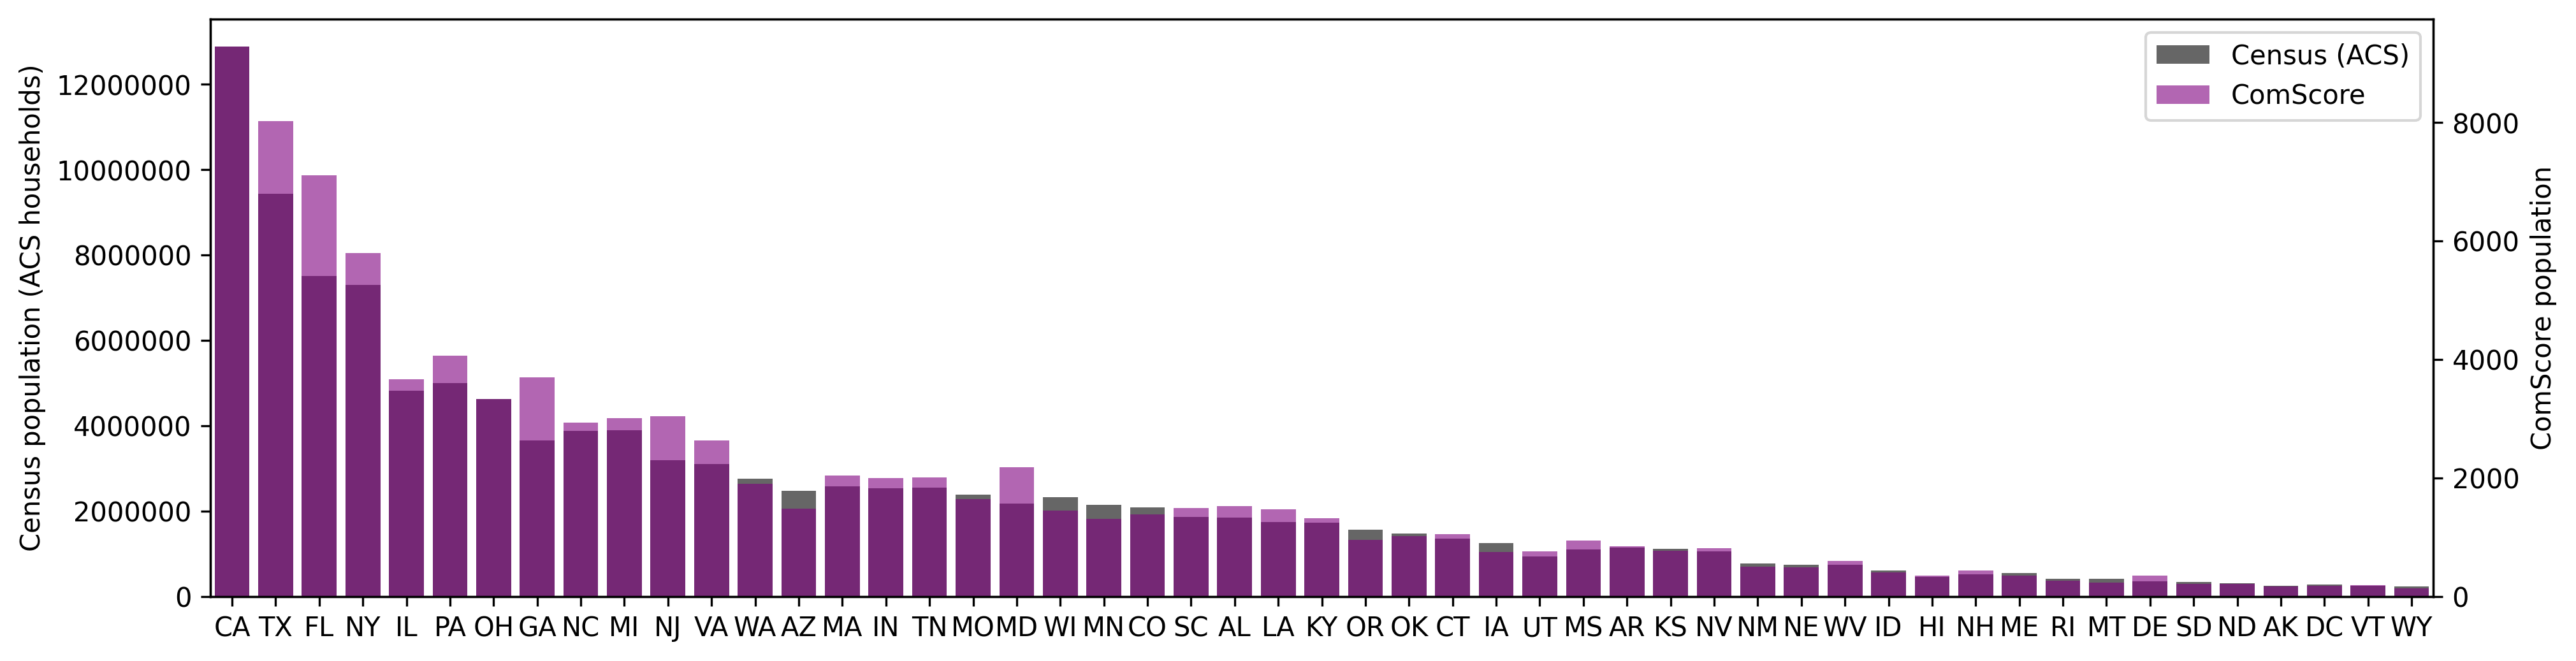

In [48]:
print('Comparing by U.S. State ACS (households) population vs comScore population\nPearson r=%0.3f (p=%0.3f)' % (
    pearsonr(state_pop_df['comscore_count'],
             state_pop_df['population estimate (households)'])))

fig,ax = plt.subplots(1,1,figsize=(15,4), dpi=300)
ax.bar(
    state_pop_df.state_abbr, state_pop_df['population estimate (households)'],
    color=c_census, alpha=0.6, label='Census (ACS)'
)
ax.ticklabel_format(useOffset=False, axis='y', style='plain')
ax.set_xlim(-0.5, len(state_pop_df)-0.5)
ax.set_ylabel('Census population (ACS households)')
ax2 = ax.twinx()
ax2.bar(
    state_pop_df.state_abbr, state_pop_df['comscore_count'],
    color=c_comscore, alpha=0.6, label='ComScore'
)
ax2.set_ylabel('ComScore population')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
_ = ax2.legend(lines + lines2, labels + labels2, loc=0)

Comparing by U.S. State ACS (total) population vs comScore population
Pearson r=0.983 (p=0.000)


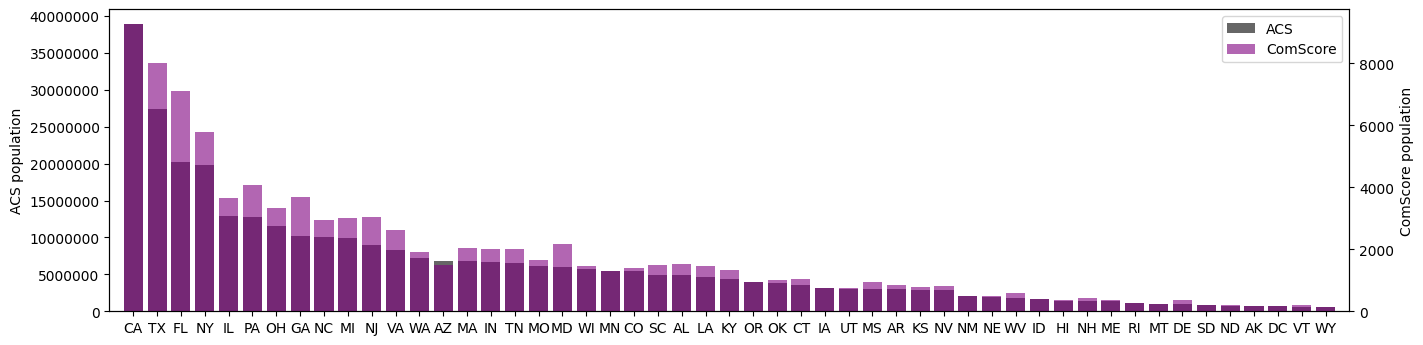

In [41]:
print('Comparing by U.S. State ACS (total) population vs comScore population\nPearson r=%0.3f (p=%0.3f)' % (
    pearsonr(state_pop_df['comscore_count'],
             state_pop_df['population estimate'])))

fig,ax = plt.subplots(1,1,figsize=(16,4), dpi=100)
ax.bar(
    state_pop_df.state_abbr, state_pop_df['population estimate'],
    color=c_census, alpha=0.6, label='ACS'
)
ax.ticklabel_format(useOffset=False, axis='y', style='plain')
ax.set_xlim(-1, len(state_pop_df))
ax.set_ylabel('ACS population')
ax2 = ax.twinx()
ax2.bar(
    state_pop_df.state_abbr, state_pop_df['comscore_count'],
    color=c_comscore, alpha=0.6, label='ComScore'
)
ax2.set_ylabel('ComScore population')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
_ = ax2.legend(lines + lines2, labels + labels2, loc=0)

## Education

In [87]:
acs_educations = acs_mapping[acs_mapping.comscore_column == 'hoh_most_education'][
    ['acs_code','comscore_code', 'description']
].set_index('acs_code')
acs_educations['count'] = acs_df.transpose()
acs_educations

,comscore_code,description,count
acs_code,,,
DP02_0064E,4,bachelors degree,41377068.0
DP02_0061E,1,high school graduate,59093612.0
DP02_0065E,5,graduate degree,25510535.0
DP02_0062E,2,"some college, no degree",44935834.0
DP02_0063E,3,associates degree,17917481.0
DP02_0060E,0,9-12 grade no diploma,15677560.0
DP02_0059E,0,less than 9th grade,11759554.0


In [88]:
# where are the zeros? Are there... zero?
demo_df['hoh_most_education'].value_counts()

3.0    21290
2.0    20562
4.0    14713
1.0     2600
5.0     2118
Name: hoh_most_education, dtype: int64

In [89]:
demo_educations = demo_df['hoh_most_education'].value_counts()
demo_educations.loc[0] = 0
demo_educations.sort_index()

0.0        0
1.0     2600
2.0    20562
3.0    21290
4.0    14713
5.0     2118
Name: hoh_most_education, dtype: int64

ComsScore vs ACS : head of household education


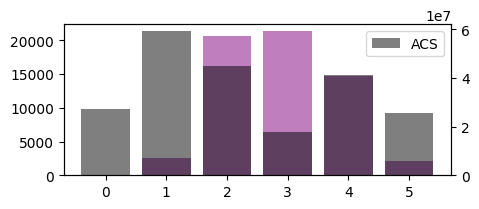

In [90]:
fig,ax = plt.subplots(1,1,figsize=(5,2), dpi=100)
labels = list(range(6))
ax.bar(labels, demo_educations.sort_index().values, 
       label='comscore',
       alpha=0.5, color=c_comscore)
ax2 = ax.twinx()
ax2.bar(labels, acs_educations.groupby('comscore_code').agg('sum')['count'], 
       label='ACS',
       alpha=0.5, color=c_census)
print('ComsScore vs ACS : head of household education')
_ = ax2.legend()

## Income

In [91]:
acs_incomes = acs_mapping[acs_mapping.comscore_column == 'household_income'][
    ['acs_code','comscore_code']
].set_index('acs_code')
acs_incomes['count'] = acs_df.transpose()
acs_incomes

,comscore_code,count
acs_code,,
DP03_0052E,1,7942251.0
DP03_0053E,1,5768114.0
DP03_0054E,1,11637905.0
DP03_0055E,2,11330288.0
DP03_0056E,2,15412493.0
DP03_0057E,2,21000314.0
DP03_0058E,3,14636046.0
DP03_0059E,3,16701857.0
DP03_0060E,4,6931136.0


In [99]:
acs_comscore_income_groups_4 = cps_comscore_income_groups_4[[
    'comscore','income group'
]].copy()
acs_comscore_income_groups_4['ACS'] = acs_incomes.groupby('comscore_code').sum()
acs_comscore_income_groups_4

,comscore,income group,ACS
collapsed_code,,,
1,21362,"less than $25,000",25348270.0
2,40932,"\$25,000 - $75,000",47743095.0
3,22444,"\$75,000 - $150,000",31337903.0
4,9070,"\$150,000 or more",14396653.0


In [100]:
pearsonr(
    acs_comscore_income_groups_4['comscore'],
    acs_comscore_income_groups_4['ACS']
)

(0.9895734782100043, 0.010426521789995702)

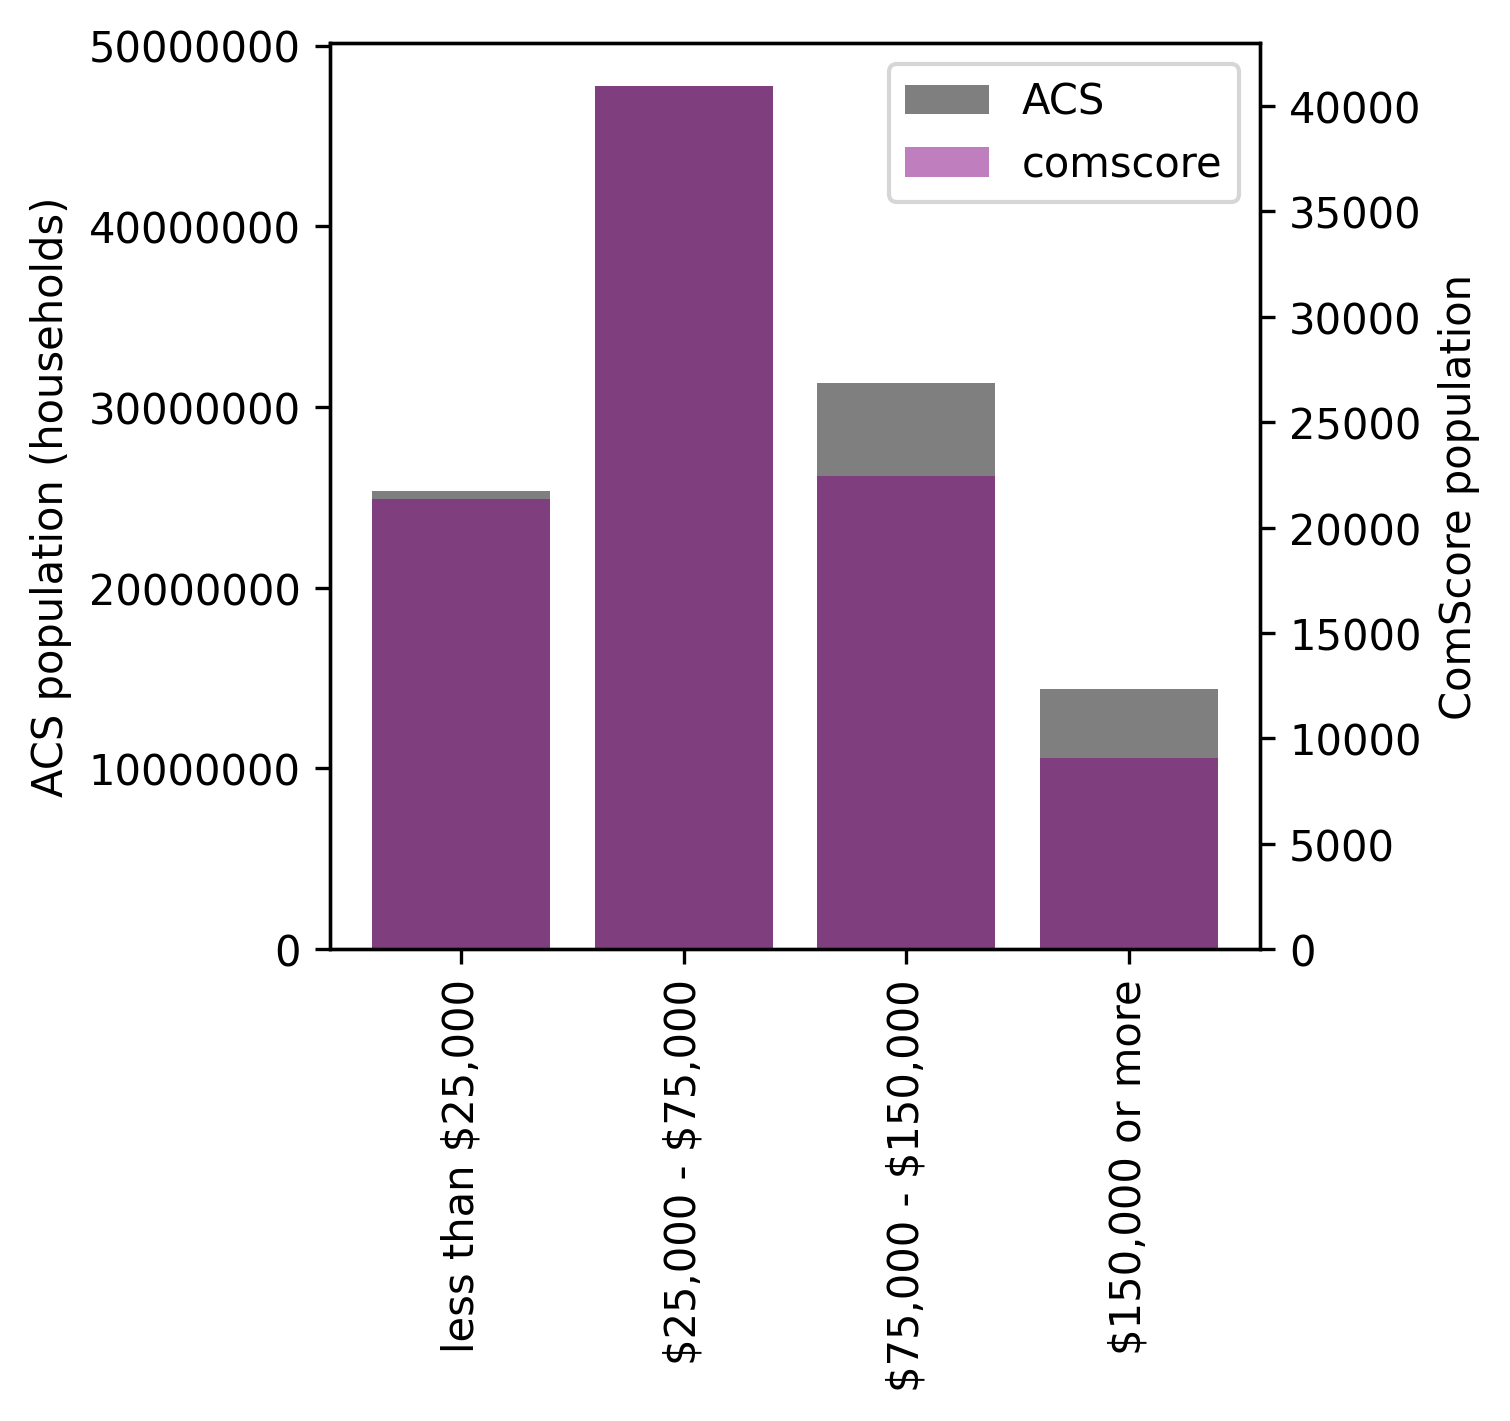

In [107]:
fig,ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)

ax.ticklabel_format(useOffset=False, axis='y', style='plain')
ax.tick_params(axis='x', labelrotation=90)

ax.bar(acs_comscore_income_groups_4['income group'],
       acs_comscore_income_groups_4['ACS'], 
       label='ACS',
       alpha=0.5, color=c_census)
ax2 = ax.twinx()
ax2.bar(acs_comscore_income_groups_4['income group'],
       acs_comscore_income_groups_4['comscore'], 
       label='comscore',
       alpha=0.5, color=c_comscore)


ax.set_ylabel('ACS population (households)')
ax2.set_ylabel('ComScore population')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
_ = ax2.legend(lines + lines2, labels + labels2, loc=0)

## State census incomes

In [ ]:
state_census_incomes = state_acs_df.transpose().loc[census_incomes.index]
state_census_incomes['comscore code'] = state_census_incomes.index.map(census_incomes['comscore_code'])
state_census_incomes = state_census_incomes.groupby('comscore code').agg('sum')
state_census_incomes

In [ ]:
states = list(demo_df['state_fips'].unique())
print('household income for ComScore data')
for state_fips in states:
    state_abbr = state_abbr_dict[state_fips]
    fig,ax = plt.subplots(1,1,figsize=(2,2))
    state_demo_df = demo_df[demo_df.state_fips == state_fips]
    state_acs_incomes = state_census_incomes[state_fips]
    ax.bar(income_codes, state_demo_df['household_income'].value_counts().drop(8).values)
    ax.set_title(state_abbr)
    ax2 = ax.twinx()
    ax2.bar(income_codes, state_acs_incomes, 
       label='ACS',
       alpha=0.5, color=c_acs)
    plt.ticklabel_format(style='plain')    # to prevent scientific notation
    plt.show()

## Race

### Country of origin / hispanic vs non-hispanic

- DP05_0071E in ACS data
- country of origin in ComScore data: hispanic = 1

In [109]:
# How many machines have no country of origin?
(len(demo_df[['country_of_origin', 'state', 'state_fips']]) \
 - len(demo_df[['country_of_origin', 'state', 'state_fips']].dropna())
)

924

In [111]:
hispanic_df = pd.DataFrame({
    'population': ['ACS', 'comscore'],
    'total': [acs_df['population estimate'][0], demo_df.country_of_origin.value_counts().sum()],
    'hispanic': [acs_df['DP05_0071E'][0], demo_df.country_of_origin.value_counts()[1]],
}).set_index('population')
hispanic_df

,total,hispanic
population,,
ACS,321004407.0,56510571.0
comscore,93808.0,14859.0


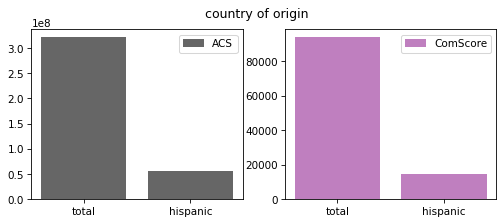

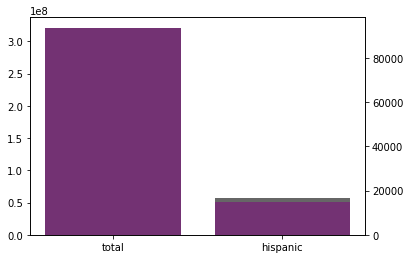

In [113]:
fig,(ax_acs, ax_comscore) = plt.subplots(1,2,figsize=(8,3), dpi=75)
ax_acs.bar(hispanic_df.loc['ACS'].index, us_hispanic_df.loc['ACS'],
       color=c_census, alpha=0.6, label='ACS')
ax_acs.legend()
fig.suptitle('country of origin')
ax_comscore.bar(hispanic_df.loc['comscore'].index,hispanic_df.loc['comscore'],
        alpha=0.5, color=c_comscore, label='ComScore')
_ = ax_comscore.legend()

fig,ax = plt.subplots(1,1)
ax.bar(hispanic_df.loc['ACS'].index, us_hispanic_df.loc['ACS'],
       color=c_census, alpha=0.6, label='ACS')
ax2 = ax.twinx()
ax2.bar(hispanic_df.loc['comscore'].index,hispanic_df.loc['comscore'],
        alpha=0.5, color=c_comscore, label='ComScore')
plt.show()

### Country of origin by state


In [114]:
# Make a vector of hispanic population pct by state
# state, ACS, Comscore
demo_hisp = demo_df[['state_fips','country_of_origin']]

state_pct_hispanic = (
    demo_hisp[demo_hisp.country_of_origin == 1].groupby('state_fips').agg('count') \
    / demo_hisp.groupby('state_fips').agg('count')
).rename(columns={'country_of_origin':'comscore'})
state_pct_hispanic['ACS'] = state_acs_df['DP05_0071E']/state_acs_df['population estimate']
state_pct_hispanic['state'] = state_pct_hispanic.index.map(state_abbr_dict)
state_pct_hispanic.sort_values('ACS', ascending=False, inplace=True)

state_pct_hispanic.head()

,comscore,ACS,state
state_fips,,,
35,0.359684,0.481624,NM
48,0.275660,0.389280,TX
06,0.309208,0.387500,CA
04,0.253531,0.308890,AZ
32,0.220732,0.281988,NV


Is this consistent across states? 

Pearson Correlation

In [115]:
r, p = pearsonr(state_pct_hispanic['ACS'], state_pct_hispanic['comscore'])
r, p

(0.9578224321106639, 3.431796496494981e-28)

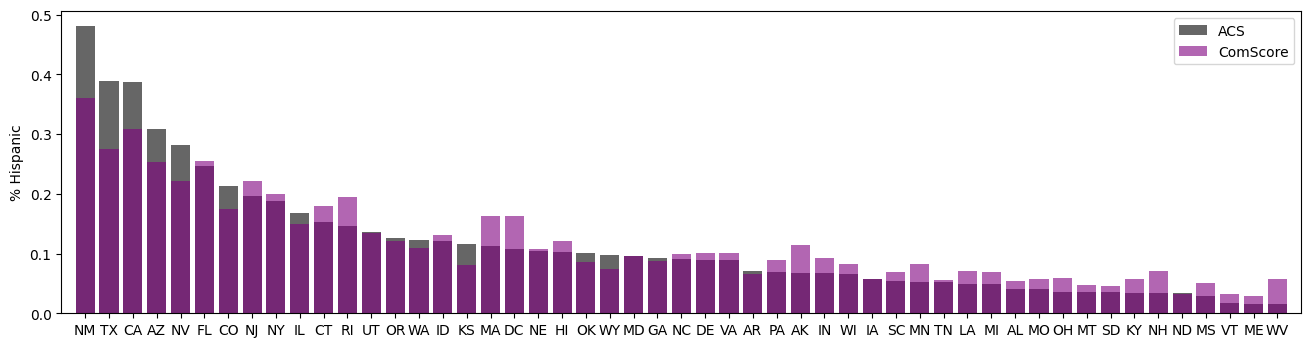

In [117]:
fig,ax = plt.subplots(1,1,figsize=(16,4), dpi=100)
ax.bar(
    state_pct_hispanic.state, state_pct_hispanic['ACS'],
    color=c_census, alpha=0.6, label='ACS'
)
ax.ticklabel_format(useOffset=False, axis='y', style='plain')
ax.set_xlim(-1, len(state_pct_hispanic))
ax.set_ylabel('% Hispanic')
ax.bar(
    state_pct_hispanic.state, state_pct_hispanic['comscore'],
    color=c_comscore, alpha=0.6, label='ComScore'
)
_ = ax.legend()

### Racial Background

- DP05_0077E	1	non-hispanic white	racial_background
- DP05_0078E	2	non-hispanic black	racial_background
- DP05_0080E	3	non-hispanic asian	racial_background
- --other---     5   non-hispanic other	racial_background

In [119]:
race_mapping = acs_mapping[acs_mapping.comscore_column=='racial_background']
race_mapping

,acs_code,comscore_code,description,comscore_column
7,DP05_0077E,1,non-hispanic white,racial_background
8,DP05_0078E,2,non-hispanic black,racial_background
9,DP05_0080E,3,non-hispanic asian,racial_background


In [123]:
# set up the census data first
us_race_df = acs_df[list(race_mapping.acs_code)].copy()
us_race_df['other'] = acs_df['population estimate'] - us_race_df.transpose().sum()
us_race_df = us_race_df.rename(
    columns=race_mapping.set_index('acs_code')['description'].to_dict()
).transpose().rename({0:'ACS'}, axis=1).sort_values('ACS', ascending=False)
# add in the comscore data
us_race_df['comscore'] = us_race_df.index.map(
    demo_df['racial_background'].value_counts()
    .rename(race_mapping.set_index('comscore_code')['description'].to_dict())
    .rename({5: 'other'})
)
us_race_df.head()

,ACS,comscore
non-hispanic white,197277789.0,56153
other,67291583.0,15036
non-hispanic black,39445495.0,17144
non-hispanic asian,16989540.0,5463


In [124]:
pearsonr(us_race_df['ACS'],us_race_df['comscore'])

(0.9838322877478396, 0.016167712252160404)

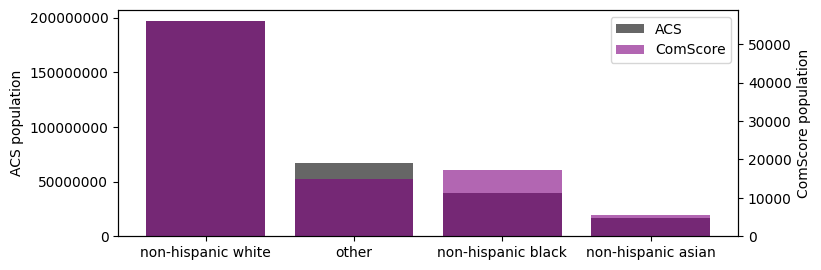

In [127]:
# plot
fig,ax = plt.subplots(1, 1, figsize=(8, 3), dpi=100)
ax.bar(
    us_race_df.index, us_race_df['ACS'],
    color=c_census, alpha=0.6, label='ACS'
)
ax.ticklabel_format(useOffset=False, axis='y', style='plain')
ax.set_ylabel('ACS population')
ax2 = ax.twinx()
ax2.bar(
    us_race_df.index, us_race_df['comscore'],
    color=c_comscore, alpha=0.6, label='ComScore'
)
ax2.set_ylabel('ComScore population')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
_ = ax2.legend(lines + lines2, labels + labels2, loc=0)

## Zip codes

So far we don't need this. but here we have it.

In [ ]:
def get_census_data_for_zip(zipcode, var_names, year=2017):
    """retrieves census variables for a given zipcode and year from the ACS
    
    parameters
    ----------
    zipcode: string. zip code to search for
    var_names: list. list of variable names from the ACS.
    
    returns
    -------
    A dict with a key for each var in var_names where the value
    is the corresponding value for the zipcode, plus a key for `state` with 
    the corresponding FIPS code and a key for `zip code tabulation area` 
    that parrots the zip.
    
    example
    -------
    >>> get_census_data_for_zip('02130', ['DP05_0080PE'])
    """
    state_fips = get_state_fips(zipcode)
    if not state_fips:
        return None
    try:
        result = c.acs5dp.state_zipcode(
            var_names,
            state_fips,
            zipcode,
            year=year)[0]
        return result
    except Exception as e:
        print("Couldn't retrieve census data for zip {}: {}".format(zipcode, e))
        return None

r = demo_df.iloc[0]
zips = list(set(demo_df.zip_code))
zip_demos = c.acs5dp.state_zipcode(list(census_mapping.census_code.values), r.state_fips, r.zip_code, year=2017)

It takes a while, so run in parallel (way faster)

In [ ]:
from joblib import Parallel, delayed
N_CORES = 24

%time zip_census_data = Parallel(n_jobs=N_CORES)(delayed(get_census_data_for_zip)(zip, acs_vars) for zip in zips)
zip_census_df = pd.DataFrame([z for z in zip_census_data if z is not None])

%mkdir ../output
zip_census_df.rename(
    columns={'zip code tabulation area': 'zip_code'}
).to_csv("../output/zip_census.csv", index=False)

script re-entry point

In [ ]:
zip_census_df = pd.read_csv("../output/zip_census.csv").set_index('zip_code')
zip_census_df.head()

In [ ]:
zip_census_df.state.nunique()

In [ ]:
len(zip_census_df)